# Data Visualizations

### Set up boto3

In [11]:
import boto3
region = boto3.Session().region_name

### Set up Sagemaker

In [12]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### Define athena database, parquet table, and athena staging directory

In [13]:
database_name = "viewboost"

In [23]:
table_name = "table1_parquet"

In [24]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [25]:
from pyathena import connect
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

### Set up Seaborn

In [26]:
import seaborn as sns
sns.set_style = "seaborn-whitegrid"

In [27]:
sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

### Setup Matplotlib

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' 

### Helper def from professor

In [28]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# (1) Average View Count by Category

### Create dataframe from athena table

In [59]:
import pandas as pd

statement = """
SELECT category, ROUND(AVG(view_count), -4) AS avg_view_count
FROM {}.{} 
GROUP BY category 
ORDER BY avg_view_count DESC
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head(5)

,category,avg_view_count
0,Music,4010000.0
1,None,3100000.0
2,Science & Technology,2550000.0
3,Film & Animation,2460000.0
4,Entertainment,2420000.0


### Visualize

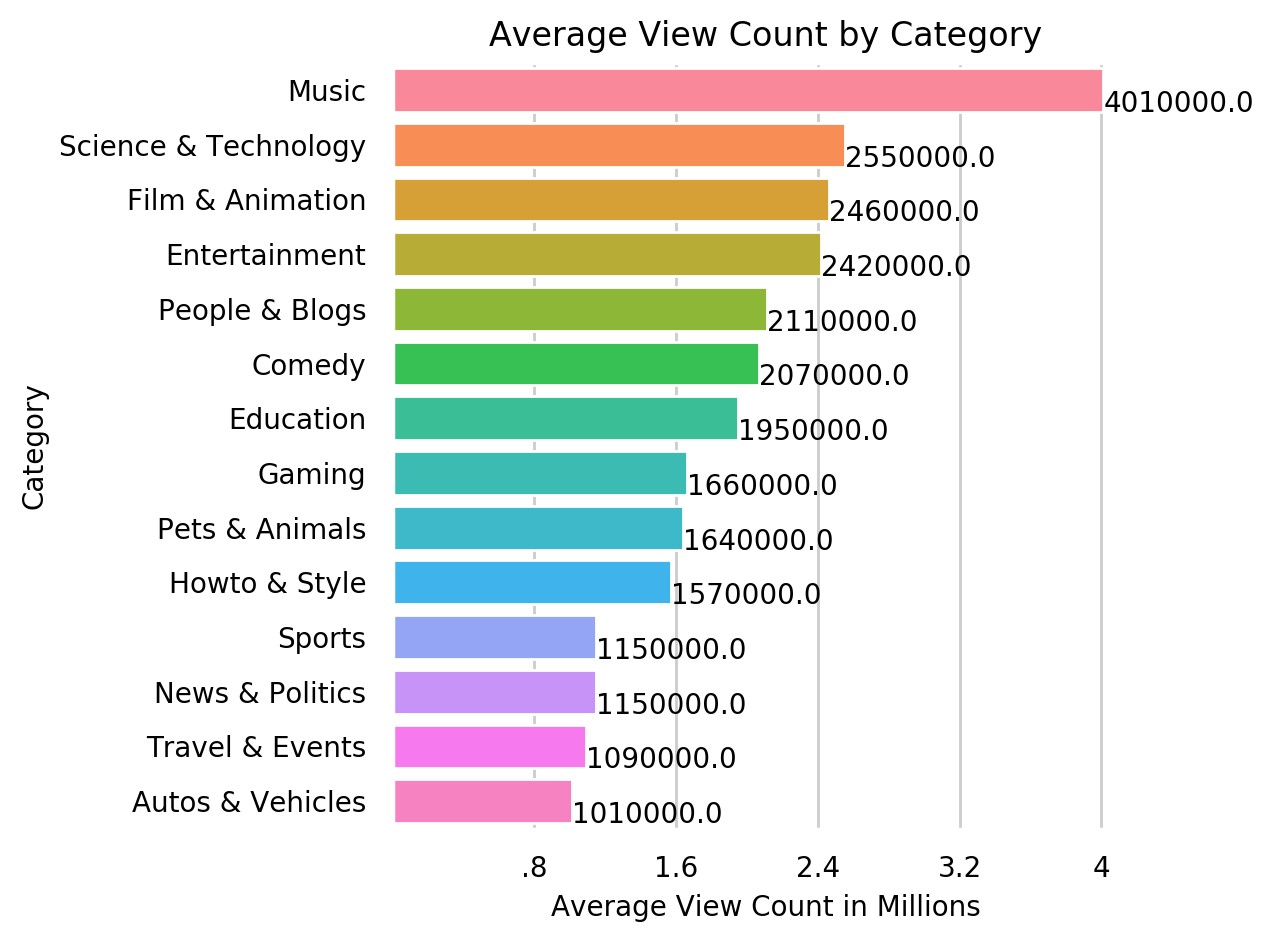

In [62]:
# Create plot
barplot = sns.barplot(y="category", x="avg_view_count", data=df, saturation=1)

sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title and x-axis ticks
plt.title("Average View Count by Category")
plt.xticks([800000, 1600000, 2400000, 3200000, 4000000], [".8", "1.6", "2.4", "3.2", "4"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.5)

plt.xlabel("Average View Count in Millions")
plt.ylabel("Category")

# Export plot if needed
#plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

# (2) Number of Videos per Category for Subset of Categories

### Create dataframe from athena table

In [65]:
statement = """
SELECT category, COUNT(view_count) AS video_count
FROM {}.{}
GROUP BY category 
ORDER BY video_count DESC
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,category,video_count
0,Entertainment,12540
1,Sports,11284
2,Gaming,9354
3,Music,8044
4,People & Blogs,5479


### Visualize

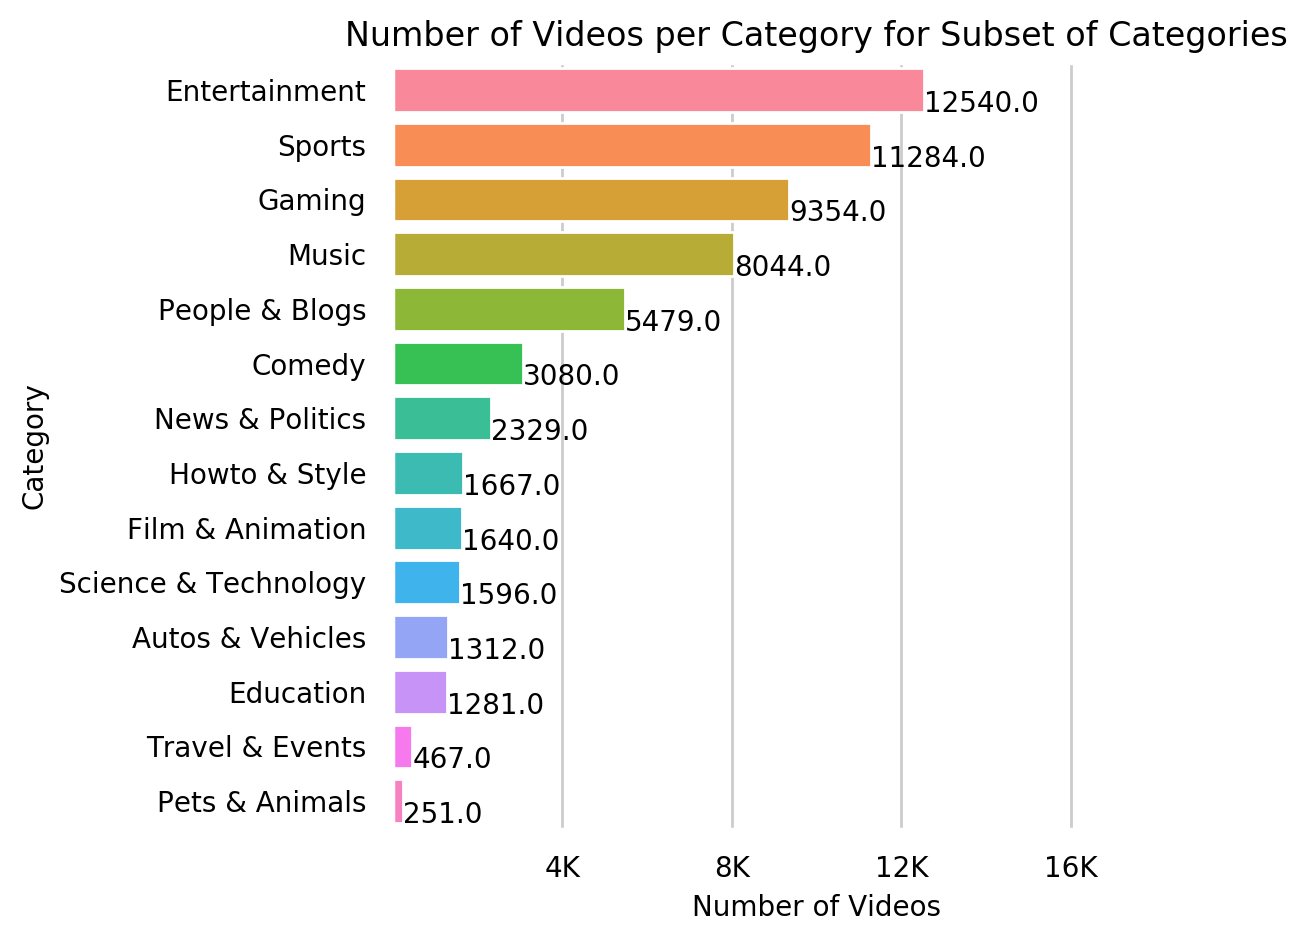

In [76]:
# Create Seaborn barplot
barplot = sns.barplot(y="category", x="video_count", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title
plt.title("Number of Videos per Category for Subset of Categories")

plt.xticks([4000, 8000, 12000, 16000], ["4K", "8K", "12K", "16K"])
plt.xlim(0, 20000)

show_values_barplot(barplot, 0.5)

plt.xlabel("Number of Videos")
plt.ylabel("Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

# (3) Breakdown of location within each category

In [81]:
# SQL statement
statement = """
SELECT category,
         location,
         COUNT(*) AS total_videos
FROM {}.{}
GROUP BY  category, location
ORDER BY  category ASC, location DESC, total_videos
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head(9)

,category,location,total_videos
0,Autos & Vehicles,US,80
1,Autos & Vehicles,GB,405
2,Autos & Vehicles,CA,827
3,Comedy,US,348
4,Comedy,GB,621
5,Comedy,CA,2111
6,Education,US,80
7,Education,GB,174
8,Education,CA,1027


In [97]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_videos_per_loc = []
i = 0

for category, ratings in df.groupby("category"):
    count_videos_per_loc = []
    for loc in ratings["location"]:
        count_videos_per_loc.append(ratings.at[i, "total_videos"])
        i = i + 1
    distribution[category] = count_videos_per_loc 
# Check if distribution has been created succesfully
print(distribution)


{'Autos & Vehicles': [80, 405, 827], 'Comedy': [348, 621, 2111], 'Education': [80, 174, 1027], 'Entertainment': [1438, 3368, 7734], 'Film & Animation': [249, 171, 1220], 'Gaming': [826, 1218, 7310], 'Howto & Style': [177, 306, 1184], 'Music': [1884, 1489, 4671], 'News & Politics': [516, 569, 1244], 'People & Blogs': [691, 1457, 3331], 'Pets & Animals': [23, 47, 181], 'Science & Technology': [83, 231, 1282], 'Sports': [1631, 4872, 4781], 'Travel & Events': [12, 155, 300]}


In [108]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1)
df_distribution_pct.columns=['US', 'GB', 'CA']
df_sorted = df_distribution_pct.sort_values(by=['US', 'GB'], ascending=[False, False])
df_sorted

,US,GB,CA
Autos & Vehicles,6.097561,30.868902,63.033537
Comedy,11.298701,20.162338,68.538961
Education,6.245121,13.583138,80.171741
Entertainment,11.467305,26.858054,61.674641
Film & Animation,15.182927,10.426829,74.390244
Gaming,8.830447,13.021167,78.148386
Howto & Style,10.617876,18.356329,71.025795
Music,23.421183,18.510691,58.068125
News & Politics,22.155432,24.431086,53.413482
People & Blogs,12.611790,26.592444,60.795766


### Visualize

<Figure size 1000x500 with 0 Axes>

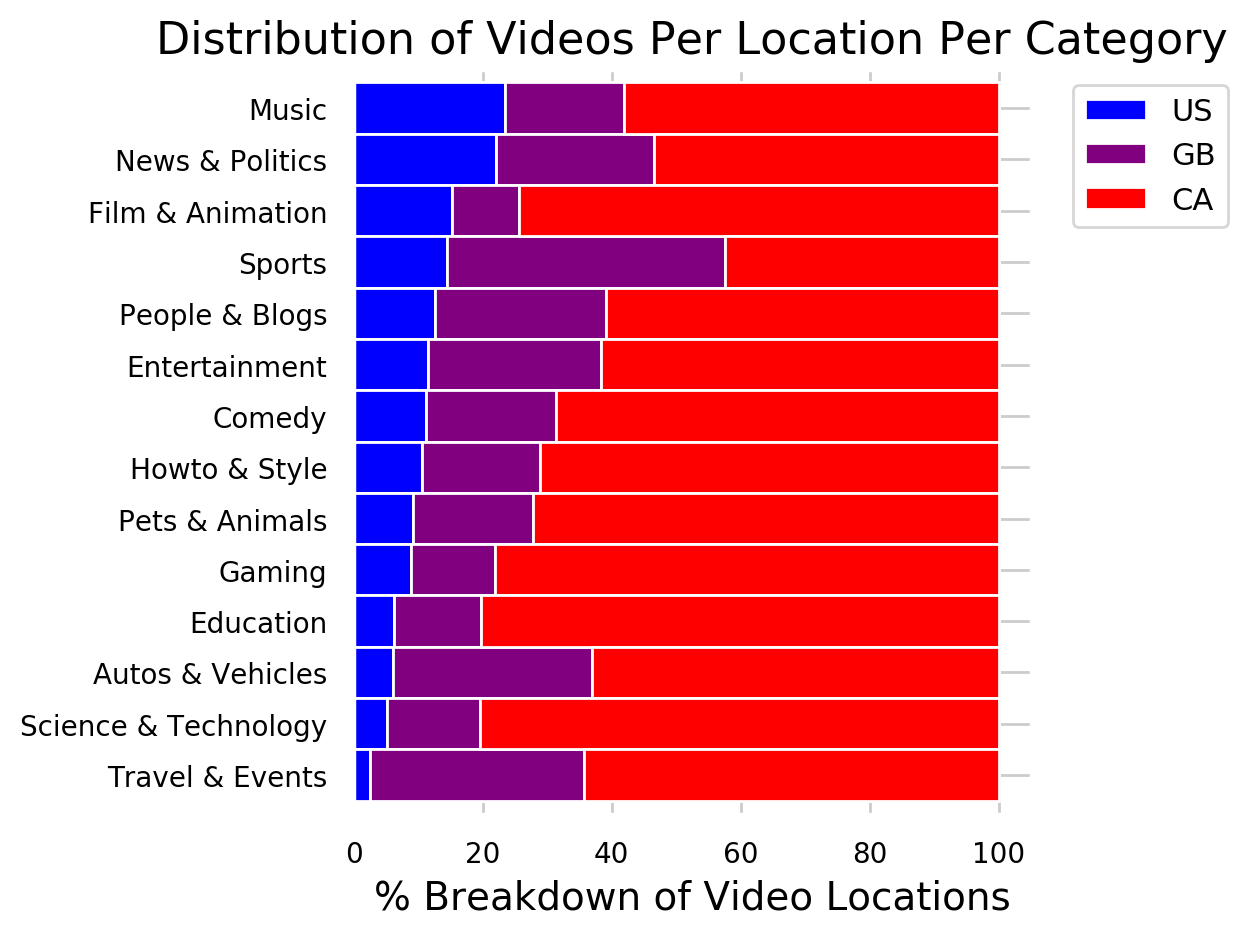

In [121]:
categories = df_sorted.index

# Plot bars
plt.figure(figsize=(10,5))

df_sorted.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['blue', 
                                       'purple', 
                                       'red'])

plt.title("Distribution of Videos Per Location Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['US', 
                   'GB', 
                   'CA'])

#show_values_barplot(, space):

plt.xlabel("% Breakdown of Video Locations", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

# (4) Trending video comment count over Time

In [146]:
# SQL statement
statement = """
SELECT trending_month, trending_year, ROUND(AVG(comment_count),4)/ 1000 AS avg_comment
FROM {}.{}
GROUP BY trending_year, trending_month
ORDER BY trending_year, trending_month
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df['date'] = df['trending_month'] + '' + df['trending_year']
df.head(3)

,trending_month,trending_year,avg_comment,date
0,08,2020,13.664870,082020
1,09,2020,11.295681,092020
2,10,2020,8.987969,102020


### Visualize

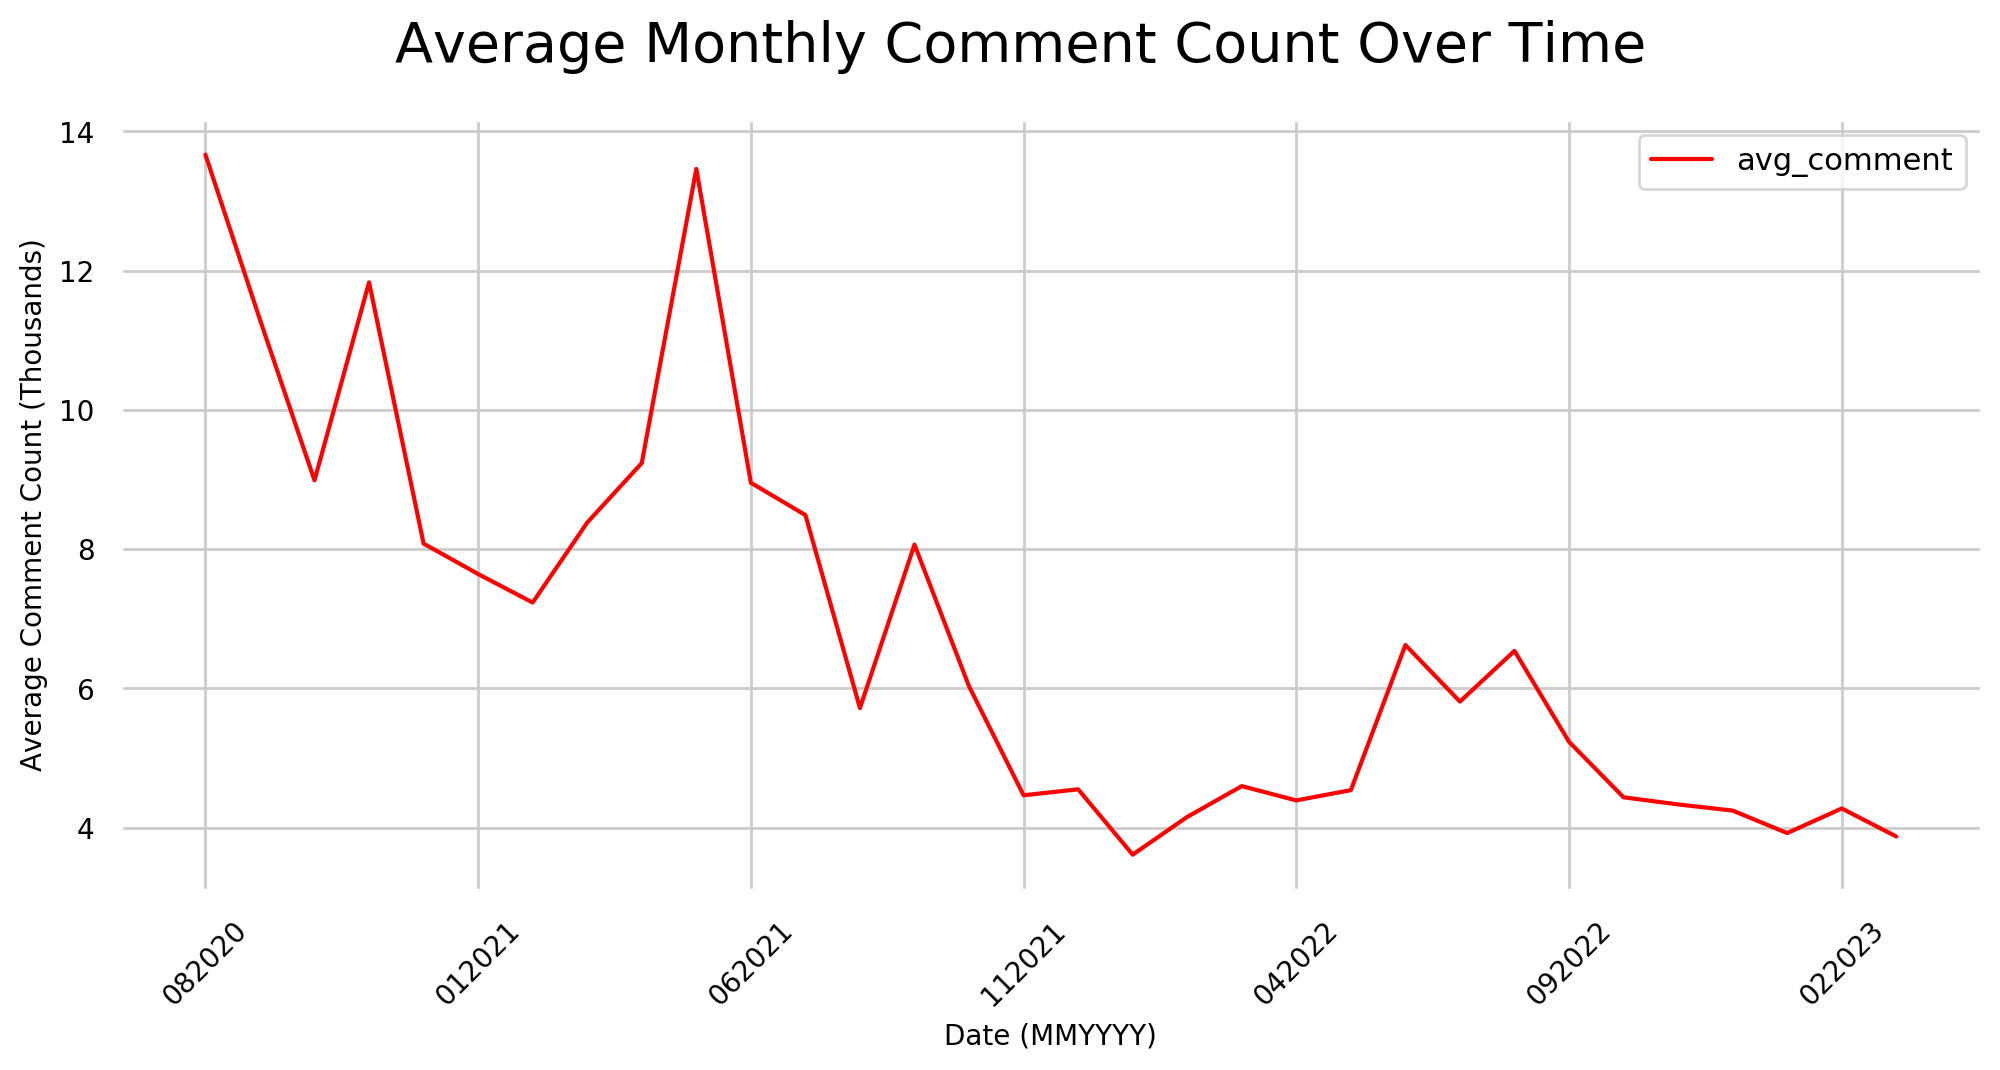

In [148]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Monthly Comment Count Over Time")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
#ax.set_xticks(df["trending_month"])

df.plot(kind="line", x="date", y="avg_comment", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Date (MMYYYY)")
plt.ylabel("Average Comment Count (Thousands)")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()